# Import libraries

In [1]:
%pip install pybamm # install PyBaMM if it is not installed
%pip install "pybamm[plot,cite]" -q
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import csv
import math

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


Note: you may need to restart the kernel to use updated packages.


In [2]:
pybamm.PARAMETER_PATH

['C:\\Users\\fussegli\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'C:\\Users\\fussegli\\Documents\\PyBAMM',
 'C:\\Users\\fussegli\\AppData\\Roaming\\Python\\Python311\\site-packages\\pybamm\\input\\parameters']

**PyBaMM** (Python Battery Mathematical Modelling) solves physics-based electrochemical DAE models by using state-of-the-art automatic differentiation and numerical solvers.  
Repository: https://github.com/pybamm-team/PyBaMM

In [3]:
pybamm.print_citations()

[1] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[2] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). Journal of Open Research Software, 9(1):14, 2021. doi:10.5334/jors.309.



# Set model

## Choose model: Doyle-Fuller-Newman (DFN)

### Select options  
Read documentation for more details https://pybamm.readthedocs.io/en/latest/source/models/base_models/base_battery_model.html

In [4]:
# Intercalation reaction
options = {"intercalation kinetics": "symmetric Butler-Volmer"} #  “symmetric Butler-Volmer” (default), “asymmetric Butler-Volmer”, “linear”, “Marcus”, or “Marcus-Hush-Chidsey”
# Thermal
options["thermal"] = "isothermal" # “isothermal” (default), “lumped”, “x-lumped”, or “x-full”.
options["calculate heat source for isothermal models"] = "false" # “false” (default) or “true”.
# Mechanics
options["particle mechanics"] = "none" # none” (default), “swelling only”, or “swelling and cracking”
options["stress-induced diffusion"] = "false" # “false” (default) or “true”. False if particle mechanics is none, true otherwise.
# Degradation
options["loss of active material"] = "none" #  “none” (default), “stress-driven”, “reaction-driven”, or “stress and reaction-driven”
options["lithium plating"] = "none" #  “none” (default), “reversible”, “partially reversible”, or “irreversible”.
options["SEI"] = "none" # “none”, "constant",reaction limited”, “solvent-diffusion limited”, “electron-migration limited”, “interstitial-diffusion limited”, or “ec reaction limited”
options["SEI film resistance"] = "none" # “none”, "distributed", "average"
options["SEI porosity change"] = "false" # “false” (default) or “true”.
# Applied Loading
options["operating mode"] = "current" #  “current” (default), “voltage”/”power”/”resistance”, “differential power”/”differential resistance”, “explicit power”/”explicit resistance”, “CCCV”.
options["working electrode"] = "both" # “both” (default) full cell, “negative” or “positive” to indicate a half-cell model.
# Particle description
options["particle"] = "Fickian diffusion" #  “Fickian diffusion” (default), “uniform profile”, “quadratic profile”, or “quartic profile”.
options["particle shape"] = "spherical" # “spherical” (default), or “no particles”, ()"user" ?)
options["particle size"] = "single" # “single” (default) or “distribution”

In [5]:
options

{'intercalation kinetics': 'symmetric Butler-Volmer',
 'thermal': 'isothermal',
 'calculate heat source for isothermal models': 'false',
 'particle mechanics': 'none',
 'stress-induced diffusion': 'false',
 'loss of active material': 'none',
 'lithium plating': 'none',
 'SEI': 'none',
 'SEI film resistance': 'none',
 'SEI porosity change': 'false',
 'operating mode': 'current',
 'working electrode': 'both',
 'particle': 'Fickian diffusion',
 'particle shape': 'spherical',
 'particle size': 'single'}

### Create model

In [6]:
model = pybamm.lithium_ion.DFN(options=options)

## Choose parameters

In [7]:
parameter_values = pybamm.ParameterValues("Chen2020")
#parameter_values = model.default_parameter_values

### Thickness

In [8]:
# Thickness [m]
Neg_cc_thickness = 2.5e-05
Neg_electrode_thickness = 69.745e-6
Sep_thickness = 20.202e-6
Pos_electrode_thickness = 69.745e-6
Pos_cc_thickness = 2.5e-05
# Height and width [m]
Electrode_height = 100e-6
Electrode_width = 100e-6

# Cell volume is deduced from above thickness and dimensions [m3]
full_thickness = Neg_cc_thickness + Neg_electrode_thickness + Sep_thickness + Pos_electrode_thickness + Pos_cc_thickness
cell_volume = full_thickness * Electrode_height * Electrode_width

# Update parameters
parameter_values.update({"Negative electrode thickness [m]": Neg_electrode_thickness})
parameter_values.update({"Separator thickness [m]": Sep_thickness})
parameter_values.update({"Positive electrode thickness [m]": Pos_electrode_thickness})
parameter_values.update({"Negative current collector thickness [m]": Neg_cc_thickness})
parameter_values.update({"Positive current collector thickness [m]": Pos_cc_thickness})
parameter_values.update({"Electrode height [m]": Electrode_height})
parameter_values.update({"Electrode width [m]": Electrode_width})
parameter_values.update({"Cell volume [m3]": cell_volume})

### Microstructure parameters

In [9]:
# Porosity
Neg_electrode_porosity = 0.404
Pos_electrode_porosity = 0.5102
Sep_porosity = 1.0

# Active material volume fraction
Neg_electrode_AM = 1-Neg_electrode_porosity
Pos_electrode_AM = 1-Pos_electrode_porosity

# Radius [m]
Neg_particle_radius = 4.547e-6
Pos_particle_radius = Neg_particle_radius

AMREX_sp_Neg = 0.4346 # [um-1]
AMREX_sp_Pos = 0.3872 # [um-1]
#AMREX_sp_Neg = AMREX_sp_Neg *3/2 # 2/3
#AMREX_sp_Pos = AMREX_sp_Pos *2/3 # 2/3 
Neg_particle_radius = 3*Neg_electrode_AM/AMREX_sp_Neg*1e-6
Pos_particle_radius = 3*Pos_electrode_AM/AMREX_sp_Pos*1e-6

# Bruggeman exponent
Ele_Neg_p = 1.61
Ele_Pos_p = 1.61
Sep_p = 1.0

Solid_Neg_p = 3.24
Solid_Pos_p = 3.61

# Update parameters
parameter_values.update({"Negative electrode porosity": Neg_electrode_porosity})
parameter_values.update({"Separator porosity": Sep_porosity})
parameter_values.update({"Positive electrode porosity": Pos_electrode_porosity})

parameter_values.update({"Negative electrode active material volume fraction": Neg_electrode_AM})
parameter_values.update({"Positive electrode active material volume fraction": Pos_electrode_AM})

parameter_values.update({"Negative particle radius [m]": Neg_particle_radius})
parameter_values.update({"Positive particle radius [m]": Pos_particle_radius})

parameter_values.update({"Negative electrode Bruggeman coefficient (electrolyte)": Ele_Neg_p})
parameter_values.update({"Positive electrode Bruggeman coefficient (electrolyte)": Ele_Pos_p})
parameter_values.update({"Separator Bruggeman coefficient (electrolyte)": Sep_p})
parameter_values.update({"Negative electrode Bruggeman coefficient (electrode)": Solid_Neg_p})
parameter_values.update({"Positive electrode Bruggeman coefficient (electrode)": Solid_Pos_p})

In [10]:
Neg_particle_radius

4.1141279337321665e-06

In [11]:
Pos_particle_radius

3.7949380165289256e-06

In [12]:
Neg_electrode_AM

0.596

In [13]:
Pos_electrode_AM

0.4898

### Material coefficients

In [14]:
parameter_values.update({"Negative electrode double-layer capacity [F.m-2]": 0.0})
parameter_values.update({"Positive electrode double-layer capacity [F.m-2]": 0.0})

#### Anode

In [15]:
# Maximum concentration [mol.m-3]
Neg_Csmax = 28000.0 

# Conducitvity [S.m-1]
Neg_AM_conductivity = 100

# Diffusivity [m2.s-1]
Neg_AM_diffusivity = 3.0e-14

# OCP [V]
def Neg_OCP(sto):
    a7 = -201.8048
    a6 = 730.918
    a5 = -1074.645
    a4 = 825.0173
    a3 = -354.3316
    a2 = 84.66978
    a1 = -10.57909
    a0 = 0.6848288
    u_eq = ((((((a7*sto+a6)*sto+a5)*sto+a4)*sto+a3)*sto+a2)*sto+a1)*sto+a0
    #a = (0.1-1.0)/(1-0)
    #b = 1.0
    #u_eq = a * sto + b

    x=sto;
    
    a1 = -1.059423355572770E-02;
    a2 = 2.443615203087110E-02;
    a3 = -1.637520788053810E-02;
    a4 = -6.542365622896410E-02;
    a5 = -4.173226059293490E-02;
    a6 = - 4.792178163846890E-01;
    a7 = - 4.364293924074990E-02;
    a8 = - 8.241166396760410E-02;

    b1 = 1.453708425609560E-02;
    b2 = 5.464261369950400E-01;
    b3 = 5.639025014475490E-01;
    b4 = 5.960370524233590E-01;
    b5 = 1.787670587868640E-01;
    b6 = - 3.845707852011820E-03;
    b7 = 9.449231893318330E-02;
    b8 = 7.746685789572230E-02;

    c1 = 9.089868397988610E-05;
    c2 = 6.270508166379020E-01;
    c3 = 7.053886409518520E-02;
    c4 = 1.409966536648620E+00;
    c5 = 7.693844911793470E-02;
    c6 = 4.112633446959460E-02;
    c7 = -2.046776012570780E-02;
    c8 = 3.593817905677970E-02;

    U1 = a1*np.tanh((x - b1)/c1) + a2*np.tanh((x - b2)/c2) + a3*np.tanh((x - b3)/c3) + a4*np.tanh((x - b4)/c4) + a5*np.tanh((x - b5)/c5) + a6*np.tanh((x - b6)/c6) + a7*np.tanh((x - b7)/c7) + a8*np.tanh((x - b8)/c8) + 6.594735004847470e-1;

    d0 = - 5.037944982759270E+01;
    d1 = - 1.228217254296760E+01;
    d2 = - 6.906367679257650E+01;
    d3 = + 3.437968012320620E+00;
    d4 = + 3.322960033709470E+01;
    d5 = + 5.913206621637760E+01;
    d6 = 1.233160814852810E+02;
    d7 = + 8.252008712749000E+01;
    d8 = -1.731504647676420E+02;

    U2 = (((((((d8*x+d7)*x+d6)*x+d5)*x+d4)*x+d3)*x+d2)*x+d1)*x+d0;

    u_eq = U1 + (U2 - U1) / (1.0 + exp(-1.0e2*(x - 1.02956203215198)));
    
    
    return u_eq


# OCP [V]
def Neg_OCP_50(sto):
    a50 = 1.849122616922419e+11
    a49 = -8.819931896222262e+11
    a48 = 1.062001604515950e+12
    a47 = 8.048790438835729e+11
    a46 = -1.060182892793802e+12
    a45 = -4.651896688128494e+12
    a44 = 8.995414013554387e+12
    a43 = -4.300349639365752e+12
    a42 = -2.142516757097118e+12
    a41 = 3.323690560807937e+12
    a40 = -6.685187880604164e+11
    a39 = -3.163161356880362e+12
    a38 = 2.470673249031745e+12
    a37 = 1.171783266082327e+12
    a36 = 2.661195602592427e+11
    a35 = -1.691500669721415e+12
    a34 = -2.547832440424103e+11
    a33 = -1.054177643187864e+12
    a32 = 2.573545837168061e+12
    a31 = -2.319617836086824e+12
    a30 = 3.497386914762157e+12
    a29 = -4.697106157391917e+11
    a28 = -4.269163383547113e+12
    a27 = 1.273993534496442e+12
    a26 = 2.884810158989975e+12
    a25 = -1.701152113674523e+12
    a24 = 3.863238732235334e+11
    a23 = 2.493387408332381e+11
    a22 = -6.014234616707753e+11
    a21 = -2.170733087417286e+12
    a20 = 3.508629254615213e+12
    a19 = 8.717504619145695e+11
    a18 = -4.013773805798723e+12
    a17 = 8.237523654266400e+11
    a16 = 2.729241854285399e+12
    a15 = -1.191208378843619e+12
    a14 = -2.671902822734573e+12
    a13 = 4.347133409197471e+12
    a12 = -3.383127439558777e+12
    a11 = 1.722486917784050e+12
    a10 = -6.253481579662831e+11
    a9 = 1.672084816724424e+11
    a8 = -3.323385542075727e+10
    a7 = 4.884980643590547e+09
    a6 = -5.218957697925340e+08
    a5 = 3.930452809855016e+07
    a4 = -1.987318921641952e+06
    a3 = 6.202857360445586e+04
    a2 = -9.445742616152827e+02
    a1 = -6.079599769084051
    a0 = 0.721379887964261
    u_eq = (((((((((((((((((((((((((((((((((((((((((((((((((a50*sto+a49)*sto+a48)*sto+a47)*sto+a46)*sto+a45)*sto+a44)*sto+a43)*sto+a42)*sto+a41)*sto+a40)*sto+a39)*sto+a38)*sto+a37)*sto+a36)*sto+a35)*sto+a34)*sto+a33)*sto+a32)*sto+a31)*sto+a30)*sto+a29)*sto+a28)*sto+a27)*sto+a26)*sto+a25)*sto+a24)*sto+a23)*sto+a22)*sto+a21)*sto+a20)*sto+a19)*sto+a18)*sto+a17)*sto+a16)*sto+a15)*sto+a14)*sto+a13)*sto+a12)*sto+a11)*sto+a10)*sto+a9)*sto+a8)*sto+a7)*sto+a6)*sto+a5)*sto+a4)*sto+a3)*sto+a2)*sto+a1)*sto+a0
    #a = (0.1-1.0)/(1-0)
    #b = 1.0
    #u_eq = a * sto + b

    return u_eq

def Neg_OCP_bis(x):

    tolerance = 1e-9
    x_threshold_1 = -0.1000000000
    x_threshold_2 = 0.0000000000
    x_threshold_3 = 0.0010000000
    x_threshold_4 = 0.0130000000
    x_threshold_5 = 0.0142500000
    x_threshold_6 = 0.0147500000
    x_threshold_7 = 0.0160000000
    x_threshold_8 = 0.0250000000
    x_threshold_9 = 0.0500000000
    x_threshold_10 = 0.0750000000
    x_threshold_11 = 0.0850000000
    x_threshold_12 = 0.0950000000
    x_threshold_13 = 0.1100000000
    x_threshold_14 = 0.1175000000
    x_threshold_15 = 0.1200000000
    x_threshold_16 = 0.1750000000
    x_threshold_17 = 0.2000000000
    x_threshold_18 = 0.2500000000
    x_threshold_19 = 0.3200000000
    x_threshold_20 = 0.4000000000
    x_threshold_21 = 0.4750000000
    x_threshold_22 = 0.5500000000
    x_threshold_23 = 0.6000000000
    x_threshold_24 = 0.6500000000
    x_threshold_25 = 0.7500000000
    x_threshold_26 = 0.8500000000
    x_threshold_27 = 0.9100000000
    x_threshold_28 = 0.9400000000
    x_threshold_29 = 0.9800000000
    x_threshold_30 = 1.0000000000
    a1_3 = 0.0000000000
    a1_2 = 0.0000000000
    a1_1 = 0.0000000000
    a1_0 = 0.7282583829
    u1 = ((a1_3 *(x-x_threshold_1) +a1_2)*(x-x_threshold_1)+a1_1)*(x-x_threshold_1)+a1_0
    a2_3 = 11926302.8817398995
    a2_2 = -23611.1304952030
    a2_1 = 0.0000000000
    a2_0 = 0.7282583829
    u2 = ((a2_3 *(x-x_threshold_2) +a2_2)*(x-x_threshold_2)+a2_1)*(x-x_threshold_2)+a2_0
    a3_3 = 1423.3287937244
    a3_2 = 16.8588316717
    a3_1 = -11.4433523452
    a3_0 = 0.7165735553
    u3 = ((a3_3 *(x-x_threshold_3) +a3_2)*(x-x_threshold_3)+a3_1)*(x-x_threshold_3)+a3_0
    a4_3 = -5714502.9081248762
    a4_2 = 7400.5837650184
    a4_1 = -10.4238623462
    a4_0 = 0.5841405110
    u4 = ((a4_3 *(x-x_threshold_4) +a4_2)*(x-x_threshold_4)+a4_1)*(x-x_threshold_4)+a4_0
    a5_3 = 266086504.1706757545
    a5_2 = -199279.9169415584
    a5_1 = -18.7091353155
    a5_0 = 0.5715129567
    u5 = ((a5_3 *(x-x_threshold_5) +a5_2)*(x-x_threshold_5)+a5_1)*(x-x_threshold_5)+a5_0
    a6_3 = -5153816.5410540095
    a6_2 = 13254.4465299317
    a6_1 = -18.4241741290
    a6_0 = 0.5455992229
    u6 = ((a6_3 *(x-x_threshold_6) +a6_2)*(x-x_threshold_6)+a6_1)*(x-x_threshold_6)+a6_0
    a7_3 = 10473.7332153562
    a7_2 = -18.2179680221
    a7_1 = -9.4465728404
    a7_0 = 0.5332130300
    u7 = ((a7_3 *(x-x_threshold_7) +a7_2)*(x-x_threshold_7)+a7_1)*(x-x_threshold_7)+a7_0
    a8_3 = 220.8860442081
    a8_2 = 50.4515717973
    a8_1 = -7.2293790934
    a8_0 = 0.4543535705
    u8 = ((a8_3 *(x-x_threshold_8) +a8_2)*(x-x_threshold_8)+a8_1)*(x-x_threshold_8)+a8_0
    a9_3 = 315.0024788525
    a9_2 = 27.9555458158
    a9_1 = -4.2926391707
    a9_0 = 0.3086026700
    u9 = ((a9_3 *(x-x_threshold_9) +a9_2)*(x-x_threshold_9)+a9_1)*(x-x_threshold_9)+a9_0
    a10_3 = 3875.0038101122
    a10_2 = 6.0345001128
    a10_1 = -2.3042322321
    a10_0 = 0.2236808206
    u10 = ((a10_3 *(x-x_threshold_10) +a10_2)*(x-x_threshold_10)+a10_1)*(x-x_threshold_10)+a10_0
    a11_3 = 769.6590680163
    a11_2 = 23.9901504802
    a11_1 = -1.0210410868
    a11_0 = 0.2051169521
    u11 = ((a11_3 *(x-x_threshold_11) +a11_2)*(x-x_threshold_11)+a11_1)*(x-x_threshold_11)+a11_0
    a12_3 = -908.5378590195
    a12_2 = 21.6956687670
    a12_1 = -0.3103403568
    a12_0 = 0.1980752154
    u12 = ((a12_3 *(x-x_threshold_12) +a12_2)*(x-x_threshold_12)+a12_1)*(x-x_threshold_12)+a12_0
    a13_3 = 1527.5780423977
    a13_2 = -31.2482302730
    a13_1 = -0.2727333486
    a13_0 = 0.1952353202
    u13 = ((a13_3 *(x-x_threshold_13) +a13_2)*(x-x_threshold_13)+a13_1)*(x-x_threshold_13)+a13_0
    a14_3 = 4762.2715022035
    a14_2 = -34.8483973948
    a14_1 = -0.4836780080
    a14_0 = 0.1920765541
    u14 = ((a14_3 *(x-x_threshold_14) +a14_2)*(x-x_threshold_14)+a14_1)*(x-x_threshold_14)+a14_0
    a15_3 = 31.2454842782
    a15_2 = -2.8116646887
    a15_1 = -0.5686274043
    a15_0 = 0.1907239671
    u15 = ((a15_3 *(x-x_threshold_15) +a15_2)*(x-x_threshold_15)+a15_1)*(x-x_threshold_15)+a15_0
    a16_3 = 105.3784526523
    a16_2 = -1.6642476972
    a16_1 = -0.5943577503
    a16_0 = 0.1561426416
    u16 = ((a16_3 *(x-x_threshold_16) +a16_2)*(x-x_threshold_16)+a16_1)*(x-x_threshold_16)+a16_0
    a17_3 = 41.5611794346
    a17_2 = -0.4942109034
    a17_1 = -0.4799855364
    a17_0 = 0.1418900814
    u17 = ((a17_3 *(x-x_threshold_17) +a17_2)*(x-x_threshold_17)+a17_1)*(x-x_threshold_17)+a17_0
    a18_3 = 2.6111111061
    a18_2 = 0.8683963411
    a18_1 = -0.2176977810
    a18_0 = 0.1218504247
    u18 = ((a18_3 *(x-x_threshold_18) +a18_2)*(x-x_threshold_18)+a18_1)*(x-x_threshold_18)+a18_0
    a19_3 = -3.7681906612
    a19_2 = 0.5794833137
    a19_1 = -0.0577389600
    a19_0 = 0.1117623333
    u19 = ((a19_3 *(x-x_threshold_19) +a19_2)*(x-x_threshold_19)+a19_1)*(x-x_threshold_19)+a19_0
    a20_3 = -3.7469598757
    a20_2 = 0.2538702860
    a20_1 = -0.0373708905
    a20_0 = 0.1089225960
    u20 = ((a20_3 *(x-x_threshold_20) +a20_2)*(x-x_threshold_20)+a20_1)*(x-x_threshold_20)+a20_0
    a21_3 = 10.0248014636
    a21_2 = -1.9343091906
    a21_1 = -0.0625202955
    a21_0 = 0.1059670509
    u21 = ((a21_3 *(x-x_threshold_21) +a21_2)*(x-x_threshold_21)+a21_1)*(x-x_threshold_21)+a21_0
    a22_3 = 41.5566659294
    a22_2 = -2.9213184960
    a22_1 = -0.1834981494
    a22_0 = 0.0946267527
    u22 = ((a22_3 *(x-x_threshold_22) +a22_2)*(x-x_threshold_22)+a22_1)*(x-x_threshold_22)+a22_0
    a23_3 = 14.3491845594
    a23_2 = -0.0132674376
    a23_1 = -0.1639550045
    a23_0 = 0.0833431322
    u23 = ((a23_3 *(x-x_threshold_23) +a23_2)*(x-x_threshold_23)+a23_1)*(x-x_threshold_23)+a23_0
    a24_3 = -3.0666412061
    a24_2 = 0.5421219431
    a24_1 = -0.0576628641
    a24_0 = 0.0769058615
    u24 = ((a24_3 *(x-x_threshold_24) +a24_2)*(x-x_threshold_24)+a24_1)*(x-x_threshold_24)+a24_0
    a25_3 = -2.1896765016
    a25_2 = 0.1101983650
    a25_1 = -0.0412377116
    a25_0 = 0.0734941533
    u25 = ((a25_3 *(x-x_threshold_25) +a25_2)*(x-x_threshold_25)+a25_1)*(x-x_threshold_25)+a25_0
    a26_3 = -0.7768499661
    a26_2 = -1.5624903228
    a26_1 = -0.0848883337
    a26_0 = 0.0682826893
    u26 = ((a26_3 *(x-x_threshold_26) +a26_2)*(x-x_threshold_26)+a26_1)*(x-x_threshold_26)+a26_0
    a27_3 = 195.1414050167
    a27_2 = -13.1494195369
    a27_1 = -0.2807771521
    a27_0 = 0.0573966245
    u27 = ((a27_3 *(x-x_threshold_27) +a27_2)*(x-x_threshold_27)+a27_1)*(x-x_threshold_27)+a27_0
    a28_3 = -58.7314709159
    a28_2 = 0.9217794841
    a28_1 = -0.5428605307
    a28_0 = 0.0424076503
    u28 = ((a28_3 *(x-x_threshold_28) +a28_2)*(x-x_threshold_28)+a28_1)*(x-x_threshold_28)+a28_0
    a29_3 = -135.0840380503
    a29_2 = -6.7708021843
    a29_1 = -0.7510292324
    a29_0 = 0.0184092621
    u29 = ((a29_3 *(x-x_threshold_29) +a29_2)*(x-x_threshold_29)+a29_1)*(x-x_threshold_29)+a29_0
    a30_3 = -6.7563615576
    a30_2 = -7.4447106160
    a30_1 = -1.1839621654
    a30_0 = -0.0004003157
    u30 = ((a30_3 *(x-x_threshold_30) +a30_2)*(x-x_threshold_30)+a30_1)*(x-x_threshold_30)+a30_0
    sign1a = np.sign(x_threshold_2-x-tolerance)
    sign1b = np.sign(x-x_threshold_2+tolerance)
    sign2a = np.sign(x_threshold_3-x-tolerance)
    sign2b = np.sign(x-x_threshold_3+tolerance)
    sign3a = np.sign(x_threshold_4-x-tolerance)
    sign3b = np.sign(x-x_threshold_4+tolerance)
    sign4a = np.sign(x_threshold_5-x-tolerance)
    sign4b = np.sign(x-x_threshold_5+tolerance)
    sign5a = np.sign(x_threshold_6-x-tolerance)
    sign5b = np.sign(x-x_threshold_6+tolerance)
    sign6a = np.sign(x_threshold_7-x-tolerance)
    sign6b = np.sign(x-x_threshold_7+tolerance)
    sign7a = np.sign(x_threshold_8-x-tolerance)
    sign7b = np.sign(x-x_threshold_8+tolerance)
    sign8a = np.sign(x_threshold_9-x-tolerance)
    sign8b = np.sign(x-x_threshold_9+tolerance)
    sign9a = np.sign(x_threshold_10-x-tolerance)
    sign9b = np.sign(x-x_threshold_10+tolerance)
    sign10a = np.sign(x_threshold_11-x-tolerance)
    sign10b = np.sign(x-x_threshold_11+tolerance)
    sign11a = np.sign(x_threshold_12-x-tolerance)
    sign11b = np.sign(x-x_threshold_12+tolerance)
    sign12a = np.sign(x_threshold_13-x-tolerance)
    sign12b = np.sign(x-x_threshold_13+tolerance)
    sign13a = np.sign(x_threshold_14-x-tolerance)
    sign13b = np.sign(x-x_threshold_14+tolerance)
    sign14a = np.sign(x_threshold_15-x-tolerance)
    sign14b = np.sign(x-x_threshold_15+tolerance)
    sign15a = np.sign(x_threshold_16-x-tolerance)
    sign15b = np.sign(x-x_threshold_16+tolerance)
    sign16a = np.sign(x_threshold_17-x-tolerance)
    sign16b = np.sign(x-x_threshold_17+tolerance)
    sign17a = np.sign(x_threshold_18-x-tolerance)
    sign17b = np.sign(x-x_threshold_18+tolerance)
    sign18a = np.sign(x_threshold_19-x-tolerance)
    sign18b = np.sign(x-x_threshold_19+tolerance)
    sign19a = np.sign(x_threshold_20-x-tolerance)
    sign19b = np.sign(x-x_threshold_20+tolerance)
    sign20a = np.sign(x_threshold_21-x-tolerance)
    sign20b = np.sign(x-x_threshold_21+tolerance)
    sign21a = np.sign(x_threshold_22-x-tolerance)
    sign21b = np.sign(x-x_threshold_22+tolerance)
    sign22a = np.sign(x_threshold_23-x-tolerance)
    sign22b = np.sign(x-x_threshold_23+tolerance)
    sign23a = np.sign(x_threshold_24-x-tolerance)
    sign23b = np.sign(x-x_threshold_24+tolerance)
    sign24a = np.sign(x_threshold_25-x-tolerance)
    sign24b = np.sign(x-x_threshold_25+tolerance)
    sign25a = np.sign(x_threshold_26-x-tolerance)
    sign25b = np.sign(x-x_threshold_26+tolerance)
    sign26a = np.sign(x_threshold_27-x-tolerance)
    sign26b = np.sign(x-x_threshold_27+tolerance)
    sign27a = np.sign(x_threshold_28-x-tolerance)
    sign27b = np.sign(x-x_threshold_28+tolerance)
    sign28a = np.sign(x_threshold_29-x-tolerance)
    sign28b = np.sign(x-x_threshold_29+tolerance)
    sign29a = np.sign(x_threshold_30-x-tolerance)
    sign29b = np.sign(x-x_threshold_30+tolerance)
    validity_1 = (sign1a + abs(sign1a))/2
    validity_2 = ((sign1b + abs(sign1b))/2 + (sign2a + abs(sign2a))/2)-1
    validity_3 = ((sign2b + abs(sign2b))/2 + (sign3a + abs(sign3a))/2)-1
    validity_4 = ((sign3b + abs(sign3b))/2 + (sign4a + abs(sign4a))/2)-1
    validity_5 = ((sign4b + abs(sign4b))/2 + (sign5a + abs(sign5a))/2)-1
    validity_6 = ((sign5b + abs(sign5b))/2 + (sign6a + abs(sign6a))/2)-1
    validity_7 = ((sign6b + abs(sign6b))/2 + (sign7a + abs(sign7a))/2)-1
    validity_8 = ((sign7b + abs(sign7b))/2 + (sign8a + abs(sign8a))/2)-1
    validity_9 = ((sign8b + abs(sign8b))/2 + (sign9a + abs(sign9a))/2)-1
    validity_10 = ((sign9b + abs(sign9b))/2 + (sign10a + abs(sign10a))/2)-1
    validity_11 = ((sign10b + abs(sign10b))/2 + (sign11a + abs(sign11a))/2)-1
    validity_12 = ((sign11b + abs(sign11b))/2 + (sign12a + abs(sign12a))/2)-1
    validity_13 = ((sign12b + abs(sign12b))/2 + (sign13a + abs(sign13a))/2)-1
    validity_14 = ((sign13b + abs(sign13b))/2 + (sign14a + abs(sign14a))/2)-1
    validity_15 = ((sign14b + abs(sign14b))/2 + (sign15a + abs(sign15a))/2)-1
    validity_16 = ((sign15b + abs(sign15b))/2 + (sign16a + abs(sign16a))/2)-1
    validity_17 = ((sign16b + abs(sign16b))/2 + (sign17a + abs(sign17a))/2)-1
    validity_18 = ((sign17b + abs(sign17b))/2 + (sign18a + abs(sign18a))/2)-1
    validity_19 = ((sign18b + abs(sign18b))/2 + (sign19a + abs(sign19a))/2)-1
    validity_20 = ((sign19b + abs(sign19b))/2 + (sign20a + abs(sign20a))/2)-1
    validity_21 = ((sign20b + abs(sign20b))/2 + (sign21a + abs(sign21a))/2)-1
    validity_22 = ((sign21b + abs(sign21b))/2 + (sign22a + abs(sign22a))/2)-1
    validity_23 = ((sign22b + abs(sign22b))/2 + (sign23a + abs(sign23a))/2)-1
    validity_24 = ((sign23b + abs(sign23b))/2 + (sign24a + abs(sign24a))/2)-1
    validity_25 = ((sign24b + abs(sign24b))/2 + (sign25a + abs(sign25a))/2)-1
    validity_26 = ((sign25b + abs(sign25b))/2 + (sign26a + abs(sign26a))/2)-1
    validity_27 = ((sign26b + abs(sign26b))/2 + (sign27a + abs(sign27a))/2)-1
    validity_28 = ((sign27b + abs(sign27b))/2 + (sign28a + abs(sign28a))/2)-1
    validity_29 = ((sign28b + abs(sign28b))/2 + (sign29a + abs(sign29a))/2)-1
    validity_30 = (sign29b + abs(sign29b))/2
    OCP = validity_1*u1 + validity_2*u2 + validity_3*u3 + validity_4*u4 + validity_5*u5 + validity_6*u6 + validity_7*u7 + validity_8*u8 + validity_9*u9 + validity_10*u10 + validity_11*u11 + validity_12*u12 + validity_13*u13 + validity_14*u14 + validity_15*u15 + validity_16*u16 + validity_17*u17 + validity_18*u18 + validity_19*u19 + validity_20*u20 + validity_21*u21 + validity_22*u22 + validity_23*u23 + validity_24*u24 + validity_25*u25 + validity_26*u26 + validity_27*u27 + validity_28*u28 + validity_29*u29 + validity_30*u30
    return OCP


# Exchange-current density [A.m-2] 
def Neg_io(c_e, c_s_surf, T,T2):
    #cs_max = Parameter("Maximum concentration in negative electrode [mol.m-3]")
    cs_max = 28000.0 # [mol.m-3]
    return 11 * (c_e/1000)** 0.5 * (c_s_surf/cs_max)** 0.5 * (1-c_s_surf/cs_max)** 0.5

# Update parameters
parameter_values.update({"Negative electrode conductivity [S.m-1]": Neg_AM_conductivity})
parameter_values.update({"Negative electrode diffusivity [m2.s-1]": Neg_AM_diffusivity})
parameter_values.update({"Negative electrode OCP [V]": Neg_OCP_50})
parameter_values.update({"Negative electrode exchange-current density [A.m-2]": Neg_io})


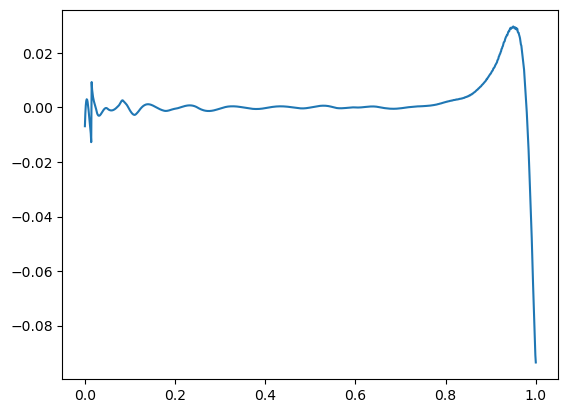

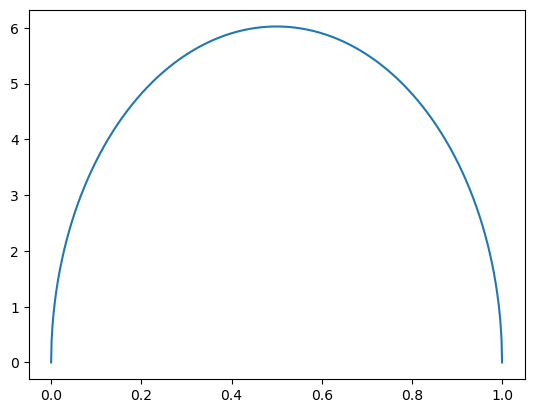

In [16]:
xs = np.linspace(0, 1, 1000)
us = np.linspace(0, 1, 1000)
io = np.linspace(0, 1, 1000)
k=-1
c_e = 1200
for x in xs:
    k=k+1
    us[k] = Neg_OCP_50(x) - Neg_OCP_bis(x)
    c_s_surf = x*28000
    io[k] = Neg_io(c_e, c_s_surf, 1,1)

plt.plot(xs, us)
plt.show()
plt.plot(xs, io)
plt.show()

#### Cathode

In [17]:
# Maximum concentration [mol.m-3]
Pos_Csmax = 49600.0

# Conducitvity [S.m-1]
Pos_AM_conductivity = 10

# Diffusivity [m2.s-1]
Pos_AM_diffusivity = 1.0e-15
def Pos_diffusivity(x,foo1):
    tolerance = 1e-9
    x_threshold_1 = -0.10000000000000000555
    x_threshold_2 = 0.00000000000000000000
    x_threshold_3 = 0.10000000000000000555
    x_threshold_4 = 0.40000000000000002220
    x_threshold_5 = 0.59999999999999997780
    x_threshold_6 = 0.80000000000000004441
    a1_3 = 0.00000000000000000000
    a1_2 = 0.00000000000000000000
    a1_1 = 0.00000000000000000000
    a1_0 = 0.00000000000000205222
    u1 = ((a1_3 *(x-x_threshold_1) +a1_2)*(x-x_threshold_1)+a1_1)*(x-x_threshold_1)+a1_0
    a2_3 = 0.00000000000000000000
    a2_2 = 0.00000000000000000000
    a2_1 = 0.00000000000000000000
    a2_0 = 0.00000000000000205222
    u2 = ((a2_3 *(x-x_threshold_2) +a2_2)*(x-x_threshold_2)+a2_1)*(x-x_threshold_2)+a2_0
    a3_3 = -0.00000000000000001127
    a3_2 = -0.00000000000000007010
    a3_1 = 0.00000000000000000000
    a3_0 = 0.00000000000000205222
    u3 = ((a3_3 *(x-x_threshold_3) +a3_2)*(x-x_threshold_3)+a3_1)*(x-x_threshold_3)+a3_0
    a4_3 = 0.00000000000000146457
    a4_2 = -0.00000000000000272898
    a4_1 = -0.00000000000000004510
    a4_0 = 0.00000000000000204560
    u4 = ((a4_3 *(x-x_threshold_4) +a4_2)*(x-x_threshold_4)+a4_1)*(x-x_threshold_4)+a4_0
    a5_3 = 0.00000000000020947640
    a5_2 = -0.00000000000006175755
    a5_1 = -0.00000000000000096095
    a5_0 = 0.00000000000000193914
    u5 = ((a5_3 *(x-x_threshold_5) +a5_2)*(x-x_threshold_5)+a5_1)*(x-x_threshold_5)+a5_0
    a6_3 = -0.00000000000000006031
    a6_2 = 0.00000000000000090514
    a6_1 = -0.00000000000000052680
    a6_0 = 0.00000000000000095246
    u6 = ((a6_3 *(x-x_threshold_6) +a6_2)*(x-x_threshold_6)+a6_1)*(x-x_threshold_6)+a6_0
    sign1a = np.sign(x_threshold_2-x-tolerance)
    sign1b = np.sign(x-x_threshold_2+tolerance)
    sign2a = np.sign(x_threshold_3-x-tolerance)
    sign2b = np.sign(x-x_threshold_3+tolerance)
    sign3a = np.sign(x_threshold_4-x-tolerance)
    sign3b = np.sign(x-x_threshold_4+tolerance)
    sign4a = np.sign(x_threshold_5-x-tolerance)
    sign4b = np.sign(x-x_threshold_5+tolerance)
    sign5a = np.sign(x_threshold_6-x-tolerance)
    sign5b = np.sign(x-x_threshold_6+tolerance)
    validity_1 = (sign1a + abs(sign1a))/2
    validity_2 = ((sign1b + abs(sign1b))/2 + (sign2a + abs(sign2a))/2)-1
    validity_3 = ((sign2b + abs(sign2b))/2 + (sign3a + abs(sign3a))/2)-1
    validity_4 = ((sign3b + abs(sign3b))/2 + (sign4a + abs(sign4a))/2)-1
    validity_5 = ((sign4b + abs(sign4b))/2 + (sign5a + abs(sign5a))/2)-1
    validity_6 = (sign5b + abs(sign5b))/2
    D = 1.5*(validity_1*u1 + validity_2*u2 + validity_3*u3 + validity_4*u4 + validity_5*u5 + validity_6*u6)
    return D




def Pos_diffusivity_20(x,foo1):
    a0 = 2.050939463450216e-15
    a1 = 4.906379385751034e-16
    a2 = -4.512662046747367e-14
    a3 = 1.743799706826960e-12
    a4 = -3.484131352926698e-11
    a5 = 3.867802051286413e-10
    a6 = -2.185952454446075e-09
    a7 = 4.481842065696113e-10
    a8 = 9.462084979990415e-08
    a9 = -8.327439324590463e-07
    a10 =  4.157435663768317e-06
    a11 = -1.420378458264979e-05
    a12 = 3.527387887933269e-05
    a13 = -6.528806014168008e-05
    a14 = 9.082307786468938e-05
    a15 = -9.465598077653415e-05
    a16 = 7.282701096327702e-05
    a17 = -4.014323811973929e-05
    a18 = 1.499682485111289e-05
    a19 = -3.401211046478066e-06
    a20 = 3.535536565858312e-07
    
    D = 1.5 * (((((((((((((((((((a20*x+a19)*x+a18)*x+a17)*x+a16)*x+a15)*x+a14)*x+a13)*x+a12)*x+a11)*x+a10)*x+a9)*x+a8)*x+a7)*x+a6)*x+a5)*x+a4)*x+a3)*x+a2)*x+a1)*x+a0
    return D



# OCP [V]
def Pos_OCP(sto):
    a3 = -1.371166
    a2 = 3.9033218
    a1 = -4.3438781
    a0 = 5.3701447
    u_eq = ((a3*sto+a2)*sto+a1)*sto+a0;    
    #a = 2
    #b = -4
    #c = 5
    #u_eq = a*sto*sto + b*sto + c
    return u_eq

def Pos_OCP_bis(sto):
    a14=-3.640118e3;
    a13=1.317658e4;
    a12=- 1.455742e4;
    a11=- 1.571094e3;
    a10=1.265631e4;
    a9=- 2.057809e3;
    a8=- 1.074374e4;
    a7=8.698113e3;
    a6=- 8.297905e2;
    a5=- 2.073765e3;
    a4=1.190223e3;
    a3=- 2.724852e2;
    a2=2.723409e1;
    a1=- 4.158277;
    a0=5.314736;
    A = (((((((((((((a14*sto+a13)*sto+a12)*sto+a11)*sto+a10)*sto+a9)*sto+a8)*sto+a7)*sto+a6)*sto+a5)*sto+a4)*sto+a3)*sto+a2)*sto+a1)*sto+a0;
    u_eq = A - 5.573191e-4 * np.exp( 6.560241 * sto**41.482093 );      

    return u_eq

def Pos_OCP_20(sto):
    a0 = 5.308816955459458
    a1 = -1.819242193096913
    a2 = -2.289403715054488e+02
    a3 = 1.206301776940133e+04
    a4 = -3.276111797393548e+05
    a5 = 5.489012058410810e+06
    a6 = -6.200450556437300e+07
    a7 = 4.979025210941446e+08
    a8 = -2.944052524805940e+09
    a9 = 1.313471799267269e+10
    a10 =  -4.496207781023888e+10
    a11 = 1.193695126040622e+11
    a12 = -2.471611537296881e+11
    a13 = 3.993607086682483e+11
    a14 = -5.011735695283248e+11
    a15 = 4.830387215923971e+11
    a16 = -3.504660079815023e+11
    a17 = 1.850688914603302e+11
    a18 = -6.710047956466081e+10
    a19 = 1.493032808692053e+10
    a20 = -1.536610516317293e+09
    
    u_eq = (((((((((((((((((((a20*sto+a19)*sto+a18)*sto+a17)*sto+a16)*sto+a15)*sto+a14)*sto+a13)*sto+a12)*sto+a11)*sto+a10)*sto+a9)*sto+a8)*sto+a7)*sto+a6)*sto+a5)*sto+a4)*sto+a3)*sto+a2)*sto+a1)*sto+a0
    return u_eq
    
def Pos_OCP_10(sto):
    a0 = 5.298113767360714
    a1 = -2.233439122750700
    a2 = -28.686773811606585
    a3 = 4.137722851474553e+02
    a4 = -3.206971022531465e+03
    a5 = 1.419463632791669e+04
    a6 = -3.727397394798015e+04
    a7 = 5.920670379229305e+04
    a8 = -5.584954194890567e+04
    a9 = 2.879351402952694e+04
    a10 =  -6.249270457540159e+03

    u_eq = (((((((((a10*sto+a9)*sto+a8)*sto+a7)*sto+a6)*sto+a5)*sto+a4)*sto+a3)*sto+a2)*sto+a1)*sto+a0
    return u_eq    


# Exchange-current density [A.m-2] 
def Pos_io(c_e, c_s_surf, T):
    #cs_max = Parameter("Maximum concentration in positive electrode [mol.m-3]")
    cs_max = 49600 # [mol.m-3]
    return 1.076 * 7 * (c_e/1000)** 0.5 * (c_s_surf/cs_max)** 0.5 * (1-c_s_surf/cs_max)** 0.5

def Pos_io_asym(c_e, c_s_surf, T, T2):
    cs_max = 49600.0 # [mol.m-3]
    x = c_s_surf/cs_max;
    a0 = 0.303490440978371;
    a1 = 1.271944700013477;
    a2 = 4.420894220185683e+02;
    a3 = -5.783762746199664e+03;
    a4 = 3.822682327855755e+04;
    a5 = -1.416477460103355e+05;
    a6 = 3.113802647858406e+05;
    a7 = -4.169011915077865e+05;
    a8 = 3.347705415406199e+05;
    a9 = -1.485221335897379e+05;
    a10 = 2.803425068966447e+04;
    P = (((((((((a10*x+a9)*x+a8)*x+a7)*x+a6)*x+a5)*x+a4)*x+a3)*x+a2)*x+a1)*x+a0;
    ce_atrest = 1200;
    return P * (c_e/ce_atrest)**0.5;      
    
# Update parameters
parameter_values.update({"Positive electrode conductivity [S.m-1]": Pos_AM_conductivity})
parameter_values.update({"Positive electrode diffusivity [m2.s-1]": Pos_diffusivity_20})
parameter_values.update({"Positive electrode OCP [V]": Pos_OCP_10})
parameter_values.update({"Positive electrode exchange-current density [A.m-2]": Pos_io_asym})

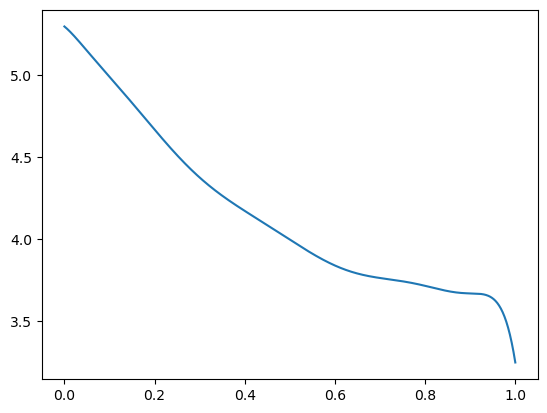

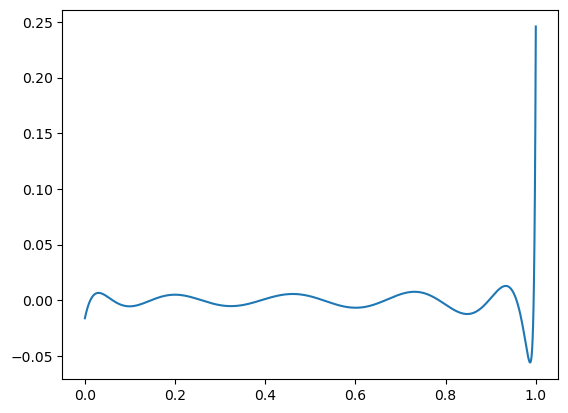

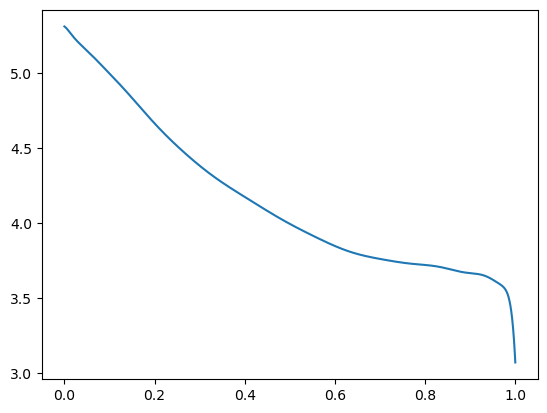

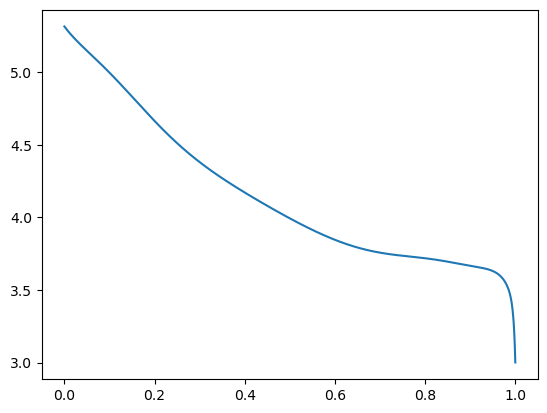

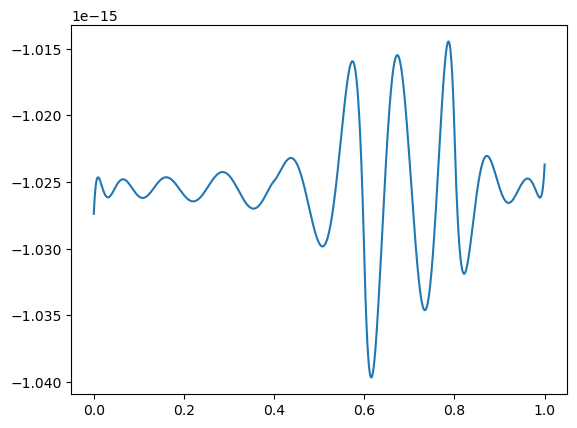

In [18]:
xs = np.linspace(0, 1, 1000)
us = np.linspace(0, 1, 1000)
k=-1
for x in xs:
    k=k+1
    us[k] = Pos_OCP_10(x)

plt.plot(xs, us)
plt.show()

k=-1
for x in xs:
    k=k+1
    us[k] = Pos_OCP_10(x)-Pos_OCP_bis(x)

plt.plot(xs, us)
plt.show()


k=-1
for x in xs:
    k=k+1
    us[k] = Pos_OCP_20(x)

plt.plot(xs, us)
plt.show()

k=-1
for x in xs:
    k=k+1
    us[k] = Pos_OCP_bis(x)

plt.plot(xs, us)
plt.show()

k=-1
for x in xs:
    k=k+1
    us[k] = Pos_diffusivity_20(x,x) - Pos_diffusivity(x,x)

plt.plot(xs, us)
plt.show()

#### Electrolyte

In [19]:
# Transference number
Ele_tplus = 0.0 # 0.46
def Ele_f_tplus(c_e,foo1):
    a0 = 0.440683
    a1 = 2.125497e-5
    a2 = -2.2667919e-09
    return (a2*c_e+a1)*c_e+a0

# 1+activity coefficient (i.e., 1 + dlnf/dlnc)
Ac_plus_one = 0.0 # 3.87 
def Ele_f_Acplusone(c_e,foo1):
    a0 = 0.806612
    a1 = -1.997683e-04
    a2 = 1.5985312e-06
    Ac = (a2*c_e+a1)*c_e+a0
    return Ac+1;

# Conducitvity [S.m-1]
Ele_conductivity = 1.0
def Ele_f_conductivity(c_e, foo1):
    a0 = 0.0
    a1 = 0.002184643837703
    a2 = -1.577170931848559e-06
    a3 = 4.120782790092705e-10
    a4 = -4.443882945301638e-14
    a5 = 1.558277114134419e-18
    Ke = ((((a5*c_e+a4)*c_e+a3)*c_e+a2)*c_e+a1)*c_e+a0;
    Ke2 = a0 + a1*c_e + a2*(c_e**2) + a3*(c_e**3) + a4*(c_e**4) + a5*(c_e**5)
    return Ke

# Diffusivity [m2.s-1]
Ele_diffusivity = 1.0e-10 
def Ele_f_diffusivity(c_e, foo1):
    a0 = 3.409857e-10
    a1 = -2.553199e-13
    a2 = 9.229720e-17
    a3 = -2.249695e-20
    a4 = 3.510337e-24
    a5 = -2.369022e-28
    return 1.0*(a0 + a1*c_e + a2*(c_e**2) + a3*(c_e**3) + a4*(c_e**4) + a5*(c_e**5))

# Update parameters
parameter_values.update({"Cation transference number": Ele_f_tplus})
parameter_values.update({"Thermodynamic factor": Ele_f_Acplusone})
parameter_values.update({"Electrolyte conductivity [S.m-1]": Ele_f_conductivity})
parameter_values.update({"Electrolyte diffusivity [m2.s-1]": Ele_f_diffusivity})


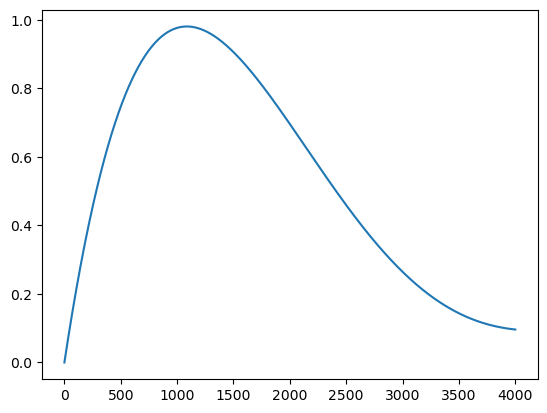

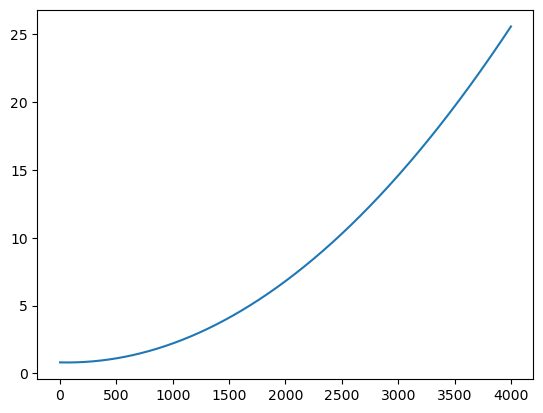

In [20]:
ce = np.linspace(0, 4000, 1000)
Ke = np.linspace(0, 1, 1000)
Ac = np.linspace(0, 1, 1000)

k=-1
for c in ce:
    k=k+1
    Ke[k] = Ele_f_conductivity(c,c)
    Ac[k] = Ele_f_Acplusone(c,c)-1


plt.plot(ce, Ke)
plt.show()
plt.plot(ce, Ac)
plt.show()

### Initial conditions

In [21]:
# Initial concentration [mol.m-3]
Sep_c_at_rest = 1200.0
Neg_C_ini = 0.1*Neg_Csmax
Pos_C_ini = 0.9*Pos_Csmax
# SOC range
Neg_SOCrange = 1.0-0.0
Pos_SOCrange = 1.0-0.4

# Update parameters
parameter_values.update({"Maximum concentration in negative electrode [mol.m-3]": Neg_Csmax})
parameter_values.update({"Maximum concentration in positive electrode [mol.m-3]": Pos_Csmax})
# parameter_values.update({"Typical electrolyte concentration [mol.m-3]": Sep_c_at_rest})

parameter_values.update({"Initial concentration in negative electrode [mol.m-3]": Neg_C_ini})
parameter_values.update({"Initial concentration in positive electrode [mol.m-3]": Pos_C_ini})
parameter_values.update({"Initial concentration in electrolyte [mol.m-3]": Sep_c_at_rest})

### Applied current and cut-off voltage

In [22]:
# C-rate
Crate = 1.0/20
low_cutoff = 0.5 # [V]
high_cutoff = 5.0 # [V]

# Active material volume [m3]
Neg_volume = Neg_electrode_thickness * Electrode_height * Electrode_width * Neg_electrode_AM
Pos_volume = Pos_electrode_thickness * Electrode_height * Electrode_width * Pos_electrode_AM
# Faraday constant [C.mol-1]
Fday = 96485.332

# Capacity [C]
Neg_theoritical_capacity = Neg_volume * Neg_Csmax * Fday
Pos_theoritical_capacity = Pos_volume * Pos_Csmax * Fday
Neg_pratical_capacity = Neg_theoritical_capacity * Neg_SOCrange
Pos_pratical_capacity = Pos_theoritical_capacity * Pos_SOCrange
Cell_pratical_capacity = np.min([Neg_pratical_capacity,Pos_pratical_capacity])
Cell_NP_ratio = Neg_pratical_capacity/Pos_pratical_capacity
Nominal_cell_capacity_Ah = Cell_pratical_capacity*3600

# Applied current
t_charge = 1/Crate * 3600 # [s]
current_1C = Cell_pratical_capacity/3600 # [A]
Applied_current = -current_1C * Crate # [A]

# Update parameters
#parameter_values.update({"Typical current [A]": Applied_current})
parameter_values.update({"Current function [A]": Applied_current})
parameter_values.update({"Nominal cell capacity [A.h]": Nominal_cell_capacity_Ah})
parameter_values.update({"Lower voltage cut-off [V]": low_cutoff})
parameter_values.update({"Upper voltage cut-off [V]": high_cutoff})

In [23]:
Applied_current

-1.3623653375411536e-08

### List parameters

In [24]:
format_str = '{:<75}  {:>20}'
print(format_str.format('PARAMETER', 'VALUE'))
print("-"*97)
for key, value in parameter_values.items():
    try:
        print(format_str.format(key, value))
    except TypeError:
        print(format_str.format(key, value.__str__()))

PARAMETER                                                                                   VALUE
-------------------------------------------------------------------------------------------------
Ideal gas constant [J.K-1.mol-1]                                                      8.314462618
Faraday constant [C.mol-1]                                                            96485.33212
Boltzmann constant [J.K-1]                                                           1.380649e-23
Electron charge [C]                                                               1.602176634e-19
Ratio of lithium moles to SEI moles                                                           2.0
Inner SEI reaction proportion                                                                 0.5
Inner SEI partial molar volume [m3.mol-1]                                               9.585e-05
Outer SEI partial molar volume [m3.mol-1]                                               9.585e-05
SEI reaction exchang

* You can explore a variety of parameters, listed under < parameter_values >.
* You can search using keyword < parameter_values >.variables.search("electrolyte").

In [25]:
#parameter_values

In [26]:
parameter_values["Negative electrode OCP [V]"]

<function __main__.Neg_OCP_50(sto)>

In [27]:
# parameter_values.search("utilisation")

### Applied loading

experiment = pybamm.Experiment(
    [
        ("Charge at 0.5 A until 4.1 V",
        "Hold at 4.1 V until 50 mA")
    ]
)

In [28]:
experiment_cycling = pybamm.Experiment(
    [
        ("Discharge at C/10 for 10 hours or until 3.3 V",
        "Rest for 1 hour",
        "Charge at 1 A until 4.1 V",
        "Hold at 4.1 V until 50 mA",
        "Rest for 1 hour"),
    ] * 1
)

experiment_CC_CV = pybamm.Experiment(
    [
        ("Charge at 0.352 A until 4.2 V",
        "Hold at 4.2 V until 50 mA"),
    ] * 1
)

experiment_CC = pybamm.Experiment(
    [
        ("Charge at 0.352 A until 4.2 V"),
    ] * 1
)

## Solver options

Documentation: https://pybamm.readthedocs.io/en/latest/source/solvers/index.html

In [29]:
solver = pybamm.CasadiSolver(atol=1e-9, rtol=1e-9, mode="fast",dt_max=0.0001,max_step_decrease_count=100)

#solver2 = pybamm.AlgebraicSolver(method='lm', tol=1e-06, extra_options=None)


## Mesh options

In [30]:
var_pts = {
    "x_n": 150,  # negative electrode
    "x_s": 30,  # separator 
    "x_p": 150,  # positive electrode
    "r_n": 100,  # negative particle
    "r_p": 100,  # positive particle
}

var_pts = {
    "x_n": 50,  # negative electrode
    "x_s": 10,  # separator 
    "x_p": 50,  # positive electrode
    "r_n": 15,  # negative particle
    "r_p": 15,  # positive particle
}

var_pts = {
    "x_n": 145,  # negative electrode
    "x_s": 41,  # separator 
    "x_p": 145,  # positive electrode
    "r_n": 15,  # negative particle
    "r_p": 15,  # positive particle
}

var_pts = {
    "x_n": 145,  # negative electrode
    "x_s": 41,  # separator 
    "x_p": 145,  # positive electrode
    "r_n": 80,  # negative particle
    "r_p": 80,  # positive particle
}

## Solve model

In [31]:
#sim = pybamm.Simulation(model,parameter_values=parameter_values,experiment=experiment_CC_CV,solver=solver,var_pts=var_pts)
sim = pybamm.Simulation(model,parameter_values=parameter_values,solver=solver,var_pts=var_pts)

In [32]:
#sim.solve()
#t_eval = np.linspace(0, 50, 50)
t_eval = np.linspace(0, 600, 600)


sim.solve(t_eval)

# Post-processing

# There are two variables for most quantities. This is because PyBaMM utilises both _dimensionless_ and _dimensional_ variables for these quantities.  
* You can explore a variety of outputs, listed under < model >.variable_names.
* You can search using keyword < model >.variables.search("electrolyte").

## Potential and concentration along cell thickness

In [33]:
output_variables = ["Negative electrode potential [V]", "Electrolyte potential [V]","Positive electrode potential [V]","R-averaged negative particle concentration [mol.m-3]", "Electrolyte concentration [mol.m-3]","R-averaged positive particle concentration [mol.m-3]"]
sim.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=600.0, step=6.0), Output()), _dom_classes=('…

## Concentration and potential averaged quantitied

In [35]:
sim.plot([["X-averaged negative electrode potential [V]", "X-averaged electrolyte potential [V]", "X-averaged positive electrode potential [V]"],"X-averaged negative electrode potential [V]", "X-averaged electrolyte potential [V]", "X-averaged positive electrode potential [V]",["Average negative particle concentration","X-averaged electrolyte concentration","Average positive particle concentration"],"Average negative particle concentration [mol.m-3]","X-averaged electrolyte concentration [mol.m-3]","Average positive particle concentration [mol.m-3]"])


KeyError: "'X-averaged electrolyte concentration' not found. Use the dimensional version 'X-averaged electrolyte concentration [Molar]' instead."

## Cell voltage component

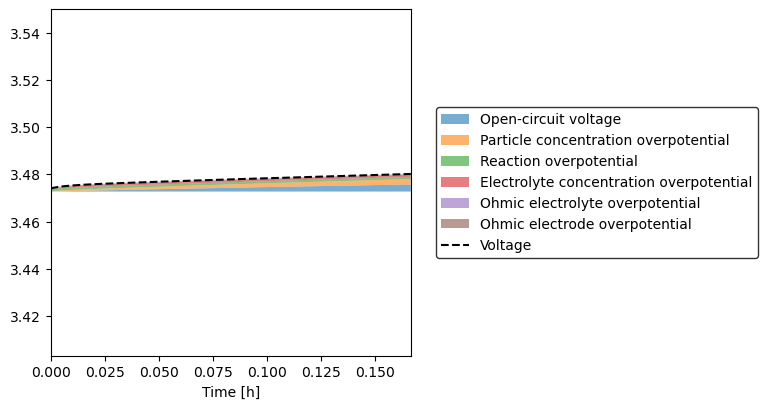

(<Figure size 800x400 with 1 Axes>, <Axes: xlabel='Time [h]'>)

In [36]:
pybamm.plot_voltage_components(sim.solution)

In [37]:
pybamm.dynamic_plot(sim.solution, ["Terminal voltage [V]"], time_unit="seconds")    

interactive(children=(FloatSlider(value=0.0, description='t', max=600.0, step=6.0), Output()), _dom_classes=('…

## Temperature

In [ ]:
sim.plot([["X-averaged negative electrode temperature [K]","X-averaged separator temperature [K]","X-averaged positive electrode temperature [K]"],"Cell temperature [K]",])

In [ ]:
model.variable_names() 

In [ ]:
model.variables.search("open")

In [ ]:
sim.plot(["X-averaged negative electrode open circuit potential [V]","X-averaged positive electrode open circuit potential [V]",])

# Export to csv

#### Access solution variables

In [38]:
solution = sim.solution

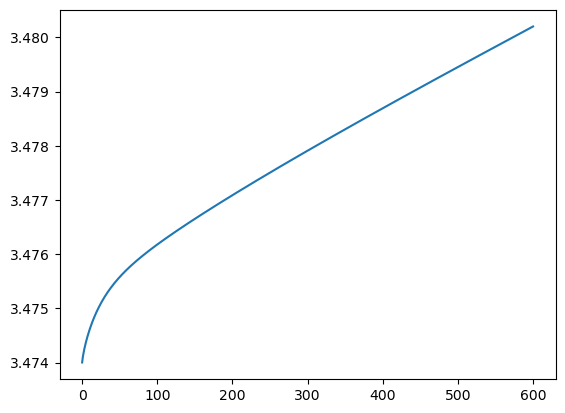

In [39]:
t = solution["Time [s]"]
V = solution["Terminal voltage [V]"]
# x = solution["x [m]"]
plt.plot(t.entries, V.entries)
plt.show()

_Averaged quantities_

In [40]:
save_avg_variables = ["Time [s]", "Current [A]", "Terminal voltage [V]","X-averaged negative electrode potential [V]", "X-averaged electrolyte potential [V]", "X-averaged positive electrode potential [V]","Average negative particle concentration [mol.m-3]","X-averaged electrolyte concentration [mol.m-3]","Average positive particle concentration [mol.m-3]"]
solution.save_data("Averaged_quantities.csv",save_avg_variables, to_format="csv")

_Along thickness quantities_

In [41]:
# X and time axis
x = solution["x [m]"]
x = x.entries[:,0]
x = np.reshape(x, (-1, 1)) # 2d array of size (n,11)
xn = solution["x_n [m]"]
xn = xn.entries[:,0]
xn = np.reshape(xn, (-1, 1)) # 2d array of size (n,11)
xp = solution["x_p [m]"]
xp = xp.entries[:,0]
xp = np.reshape(xp, (-1, 1)) # 2d array of size (n,11)

t = solution["Time [s]"]
t = np.concatenate(([-1], t.entries), axis=0)
t = np.reshape(t, (1, -1)) # 2d array of size (n,11)

In [42]:
save_along_cell_thickness_variables = ["Electrolyte potential [V]","Electrolyte concentration [mol.m-3]","Cell temperature [K]"]
for var in save_along_cell_thickness_variables:
    with open((var + '.csv'),"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        new = np.concatenate((x, solution[var].entries), axis=1) # Add thickness axis
        new = np.concatenate((t, new), axis=0) # Add time axis
        csvWriter.writerows(new)
        
save_along_anode_thickness_variables = ["Negative electrode potential [V]","R-averaged negative particle concentration [mol.m-3]"]
for var in save_along_anode_thickness_variables:
    with open((var + '.csv'),"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        new = np.concatenate((xn, solution[var].entries), axis=1) # Add thickness axis
        new = np.concatenate((t, new), axis=0) # Add time axis
        csvWriter.writerows(new)
        
save_along_cathode_thickness_variables = ["Positive electrode potential [V]","R-averaged positive particle concentration [mol.m-3]"]
for var in save_along_cathode_thickness_variables:
    with open((var + '.csv'),"w+") as my_csv:
        csvWriter = csv.writer(my_csv,delimiter=',')
        new = np.concatenate((xp, solution[var].entries), axis=1) # Add thickness axis
        new = np.concatenate((t, new), axis=0) # Add time axis
        csvWriter.writerows(new)       

        
        
        

In [ ]:
t

In [ ]:
pwd